In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My \Drive/Sem \8 \files/
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Sem 8 files
 data				  __pycache__
 euclidean_distances.json	  Shortest_path_lengths.pkl
'Fri Feb 14 09_06_16 2020.json'   utils.py


In [2]:
!apt-get install -y libspatialindex-c4v5
!pip3.6 install osmnx

import osmnx as ox
import networkx as nx
import pandas as pd
import json
import random
import statistics
import numpy as np

from rtree import index
from utils import *

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-c4v5 is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [3]:
place_name = "Singapore, Central, Singapore"
G = ox.save_load.load_graphml(filename="Singapore_drive_processed.graphml")

# Stores nodes and edges mapped with speed bands along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [0]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
nodes = pd.read_pickle('data/nodes_drive.pkl')

In [5]:
f = open("Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)

/content/drive/My Drive/Sem 8 files/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MaximumSpeed'][i] = '80'


In [0]:
calculate_congestion(G, edges, speed_bands)

In [0]:
# key: node label ,value: location
idx = index.Index('data/bus_stops')

### Showing that hybrid search gives optimal solution always.

In [0]:
def find_nearest_nodes(source, dist, idx):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    candidate_nodes = list(idx.intersection((west, south, east, north)))    
    return candidate_nodes

In [0]:
def get_length_dict(sources, destinations, method='euclidean'):
    distances = dict()
    
    if method == 'euclidean':
        for source in sources:        
            for dest in destinations:
                ed = haversine_distance(nodes, source, dest)
                distances[source,dest] = ed/13.8889
    else:
        for source in sources:        
            for dest in destinations:
                try:
                    # dijsktra distance in sec
                    d = nx.shortest_path_length(G, source, dest, weight='BPR', method='dijkstra')
                except nx.NetworkXUnfeasible:
                    d = float('inf')
                distances[(source,dest)] = d
       
    # sort the dictionary in ascending order using distances
    x = sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))
    return x    

In [0]:
def lets_do_this():
  # get 10 random sources
  sources = []
  for i in range(10):
      r = random.randint(0,23210)
      s = nodes['osmid'].values[r]
      sources.append(s)
      
  # get 10 correspondig random targets
  targets = []
  for i in range(10):
      r = random.randint(0,23210)
      t = nodes['osmid'].values[r]
      targets.append(t)

  hybrid = []
  exhaustive = []
  for s,t in zip(sources,targets):
      orig_point = nodes[nodes['osmid'] == s].geometry.values[0]
      target_point = nodes[nodes['osmid'] == t].geometry.values[0]
      orig_xy = (orig_point.y, orig_point.x)
      target_xy = (target_point.y, target_point.x)
      
      # Max distance for walking is 720m (10 min * 1.2 m/s)
      # Find all nodes within 720 m from candidate sources and candidate destinations
      candidate_dest = find_nearest_nodes(target_xy, 720, idx)
      candidate_source = find_nearest_nodes(orig_xy, 720, idx)
      
      real_lengths = dict(get_length_dict(candidate_source, candidate_dest, method='dijkstra'))
      euclidean = get_length_dict(candidate_source, candidate_dest)
      
      # value1: hybrid, value2: exhaustive
      value1 = hybrid_search_length(G, euclidean, real_lengths)
      hybrid.append(value1)

      key = next(iter(real_lengths))      
      value2 = real_lengths[key]
      exhaustive.append(value2)

      print(s, t, value1, value2)
      
  # take mean of deviations
  return hybrid, exhaustive

In [11]:
hybrid, exhaustive = lets_do_this()

1357035001 439978014 1753.1214903962173 1753.1214903962173
7013732721 6038625552 803.308563702108 803.308563702108
1818808468 246801940 1389.3701809723025 1389.3701809723025
6278098444 158016522 1067.055560325606 1067.055560325606
243507369 1539883549 609.6308891929929 609.6308891929929
1205809969 1110929999 2532.638681321187 2532.638681321187
248018507 7018501234 248.401565945956 248.401565945956
1389166375 6979507962 0 0
4606359556 246294533 1132.9601062889915 1132.9601062889915
5171971636 1347469864 1245.205902731469 1245.205902731469


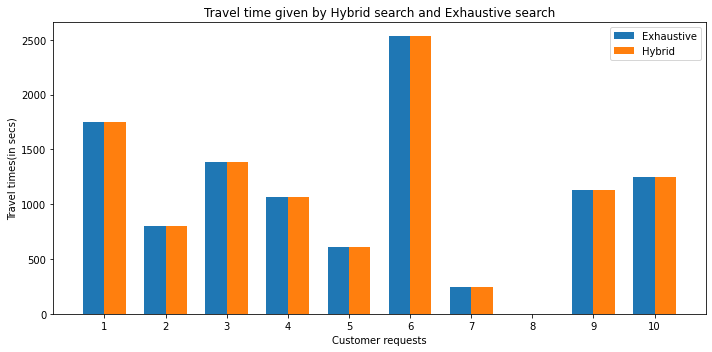

In [25]:
# Plot them
import matplotlib.pyplot as plt

labels = [x for x in range(1,11)]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, exhaustive, width, label='Exhaustive')
rects2 = ax.bar(x + width/2, hybrid, width, label='Hybrid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Travel times(in secs)')
ax.set_xlabel('Customer requests')
ax.set_title('Travel time given by Hybrid search and Exhaustive search')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()